In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import mlflow
import mlflow.tensorflow

In [12]:
df = pd.read_csv('data_limpieza.csv')
#df = df.head(100000)

# Variable de respuesta (última columna)
y = df['PUNT_GLOBAL']

# Variables de entrada (solo las columnas especificadas)
columnas_X = ['PERIODO', 'COLE_AREA_UBICACION', 'COLE_BILINGUE', 'COLE_CALENDARIO',
       'COLE_CARACTER', 'COLE_DEPTO_UBICACION', 'COLE_GENERO', 'COLE_JORNADA',
       'COLE_MCPIO_UBICACION', 'COLE_NATURALEZA',
       'COLE_NOMBRE_ESTABLECIMIENTO', 'COLE_NOMBRE_SEDE', 'ESTU_GENERO',
       'ESTU_PRIVADO_LIBERTAD', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONMADRE',
       'FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR',
       'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET',
       'FAMI_TIENELAVADORA']

X= df[columnas_X]
# Definir rangos de puntajes y crear etiquetas de clasificación
bins = [0, 250, 350, float('inf')]
labels = [0, 1, 2]  # 0: Bajo, 1: Medio, 2: Alto
df['PUNT_GLOBAL_BIN'] = pd.cut(df['PUNT_GLOBAL'], bins=bins, labels=labels, right=False)

# Variables de entrada (todas menos 'PUNT_GLOBAL' y 'PUNT_GLOBAL_BIN')
#X = df.drop(columns=['PUNT_GLOBAL', 'PUNT_GLOBAL_BIN'])
# Variable de salida
y = df['PUNT_GLOBAL_BIN']

# Columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numeric_columns = X.select_dtypes(include=['number']).columns.tolist()

# Preprocesamiento: OneHotEncoding para variables categóricas, escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Preprocesar los datos
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Convertir y_train y y_test a números enteros
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [13]:
df.head()

,PERIODO,COLE_AREA_UBICACION,COLE_BILINGUE,COLE_CALENDARIO,COLE_CARACTER,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,COLE_MCPIO_UBICACION,COLE_NATURALEZA,...,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,DESEMP_INGLES,PUNT_INGLES,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL,PUNT_GLOBAL_BIN
0,20192,URBANO,N,A,TÉCNICO/ACADÉMICO,SANTANDER,MIXTO,MAÑANA,BUCARAMANGA,OFICIAL,...,Si,Si,A2,61.0,64,49,59,63,295,1
1,20192,URBANO,N,A,TÉCNICO/ACADÉMICO,SANTANDER,MIXTO,MAÑANA,BUCARAMANGA,OFICIAL,...,Si,Si,A2,61.0,64,49,59,63,295,1
2,20192,RURAL,N,A,ACADÉMICO,SANTANDER,MIXTO,MAÑANA,CHARALÁ,OFICIAL,...,No,Si,A1,54.0,69,55,48,57,285,1
3,20192,RURAL,N,A,ACADÉMICO,SANTANDER,MIXTO,MAÑANA,CHARALÁ,OFICIAL,...,No,Si,A1,54.0,69,55,48,57,285,1
4,20192,URBANO,N,A,TÉCNICO,NORTE SANTANDER,MIXTO,ÚNICA,VILLA DEL ROSARIO,OFICIAL,...,Si,Si,A-,37.0,45,50,51,47,237,0


In [14]:
neurons = 128
activation = "relu"
optimizer = "Adam"
epocas = 15
input_shape = (X_train.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(neurons, activation=activation, kernel_initializer="he_normal"),
    tf.keras.layers.Dense(neurons // 2, activation=activation, kernel_initializer="he_normal"),
    tf.keras.layers.Dense(3, activation='softmax')  # Cambiar a softmax para clasificación multiclase
])

# Compilar el modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=epocas, validation_data=(X_test, y_test))


Epoch 1/15
2981/2981 [==============================] - 12s 4ms/step - loss: 0.7009 - accuracy: 0.6566 - val_loss: 0.6803 - val_accuracy: 0.6700
Epoch 2/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.6642 - accuracy: 0.6785 - val_loss: 0.6634 - val_accuracy: 0.6832
Epoch 3/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.6278 - accuracy: 0.7009 - val_loss: 0.6484 - val_accuracy: 0.6921
Epoch 4/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.5800 - accuracy: 0.7301 - val_loss: 0.6390 - val_accuracy: 0.6986
Epoch 5/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.5290 - accuracy: 0.7573 - val_loss: 0.6183 - val_accuracy: 0.7129
Epoch 6/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.4797 - accuracy: 0.7848 - val_loss: 0.6099 - val_accuracy: 0.7266
Epoch 7/15
2981/2981 [==============================] - 11s 4ms/step - loss: 0.4335 - accuracy: 0.8096 - val_loss: 0.5967 - val_a

In [15]:
# Predicciones
y_pred_train = model.predict(X_train).argmax(axis=1)
y_pred_test = model.predict(X_test).argmax(axis=1)

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')
auc_score = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

746/746 [==============================] - 1s 2ms/step


746/746 [==============================] - 1s 2ms/step


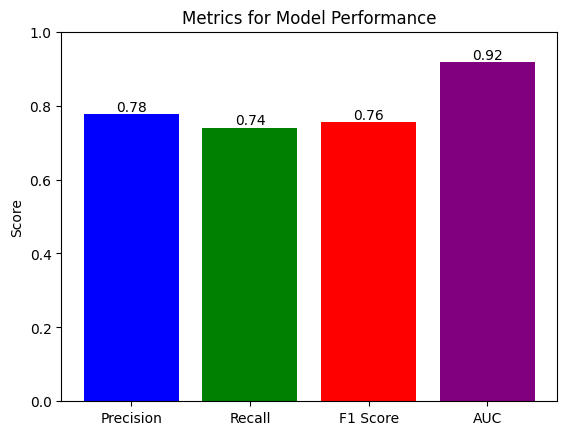

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')
auc_score = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

# Crear un diccionario de métricas
metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

# Configurar el gráfico
fig, ax = plt.subplots()
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Crear gráfico de barras
bars = ax.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'purple'])

# Añadir etiquetas y título
ax.set_ylabel('Score')
ax.set_title('Metrics for Model Performance')
ax.set_ylim(0, 1)  # Asumiendo que las métricas están entre 0 y 1

# Añadir valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


In [17]:
model.save('Modelo_Clasificacion_Proy3.keras')

Regresión

In [18]:
# Cargar y preparar los datos
df = pd.read_csv('data_limpieza.csv')
df = df.head(70000)
df = df.dropna()
# df = df.iloc[50000:]

# Variables de entrada (solo las columnas especificadas)
columnas_X = ['PERIODO', 'COLE_AREA_UBICACION', 'COLE_BILINGUE', 'COLE_CALENDARIO',
       'COLE_CARACTER', 'COLE_DEPTO_UBICACION', 'COLE_GENERO', 'COLE_JORNADA',
       'COLE_MCPIO_UBICACION', 'COLE_NATURALEZA',
       'COLE_NOMBRE_ESTABLECIMIENTO', 'COLE_NOMBRE_SEDE', 'ESTU_GENERO',
       'ESTU_PRIVADO_LIBERTAD', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONMADRE',
       'FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR',
       'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET',
       'FAMI_TIENELAVADORA']  # , 'DESEMP_INGLES', 'PUNT_INGLES','PUNT_MATEMATICAS', 'PUNT_SOCIALES_CIUDADANAS', 'PUNT_C_NATURALES', 'PUNT_LECTURA_CRITICA'

X = df[columnas_X]
# Variable de salida
y = df['PUNT_GLOBAL']

# Columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numeric_columns = X.select_dtypes(include=['number']).columns.tolist()

# Preprocesamiento: OneHotEncoding para variables categóricas, escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Preprocesar los datos
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Convertir y_train y y_test a números flotantes
y_train = y_train.to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)


In [19]:
def build_model(activation, neurons, input_shape):
    tf.random.set_seed(42)
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(neurons, activation=activation, kernel_initializer="he_normal"),
        tf.keras.layers.Dense(neurons // 2, activation=activation, kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1)
    ])

def build_and_train_model(optimizer, activation, neurons):
    input_shape = (X_train.shape[1],)  # Asignar forma de entrada
    model = build_model(activation, neurons, input_shape)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_absolute_error", "mean_absolute_percentage_error"])
    return model, model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [20]:
#Corro el modelo final

# Optimizer, activation, and neurons settings
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
activacion = 'linear'
neuronas = 64

# Entrenar el modelo y obtener el historial
retorno=build_and_train_model(optimizer,activacion,neuronas)
model=retorno[0]
history_final = retorno[1]

Epoch 1/5
1750/1750 [==============================] - 6s 3ms/step - loss: 4079.2175 - mean_absolute_error: 42.1557 - mean_absolute_percentage_error: 16.5253 - val_loss: 1542.9930 - val_mean_absolute_error: 31.7332 - val_mean_absolute_percentage_error: 12.6903
Epoch 2/5
1750/1750 [==============================] - 5s 3ms/step - loss: 1514.2754 - mean_absolute_error: 31.3504 - mean_absolute_percentage_error: 12.4641 - val_loss: 1554.5212 - val_mean_absolute_error: 31.6431 - val_mean_absolute_percentage_error: 12.4235
Epoch 3/5
1750/1750 [==============================] - 5s 3ms/step - loss: 1505.6871 - mean_absolute_error: 31.2159 - mean_absolute_percentage_error: 12.4014 - val_loss: 1556.9288 - val_mean_absolute_error: 31.6590 - val_mean_absolute_percentage_error: 12.3511
Epoch 4/5
1750/1750 [==============================] - 5s 3ms/step - loss: 1503.1351 - mean_absolute_error: 31.1930 - mean_absolute_percentage_error: 12.3871 - val_loss: 1541.0269 - val_mean_absolute_error: 31.6265 - 

In [21]:
model.save('Modelo_regresion_Proy3.keras')